# Lab 5 Sparse Spam Classification 

This notebook provides an example of an app to classify phone SMS messages as either "spam" or "ham" (=not spam).  Some of this content has been adapted from a tutorial by Radimre Hurek:  https://radimrehurek.com/data_science_python/ and has been updated by Dr. Riley.  

Please follow through this notebook linearly and insert your modifications and additions appropriately throughout.  You will also need to update some of the existing cells to conform to the style expectations of the checklist.  

### Lets start with importing some things...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import nltk
import sys
from collections import Counter
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to
[nltk_data]     /home/ad.msoe.edu/singkhamj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ad.msoe.edu/singkhamj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ad.msoe.edu/singkhamj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Part 1: Load data, explore

Let's get the dataset and put it in the data folder.

This file contains **a collection of more than 5 thousand SMS phone messages** (see the `readme` file for more info).  First, load them using Pandas with one column named `label` and one named `message`...

In [2]:
messages = pandas.read_csv('/data/cs2300/L5/SMSSpamCollection.txt', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
print(messages)

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
5     spam  FreeMsg Hey there darling it's been 3 week's n...
6      ham  Even my brother is not like to speak with me. ...
7      ham  As per your request 'Melle Melle (Oru Minnamin...
8     spam  WINNER!! As a valued network customer you have...
9     spam  Had your mobile 11 months or more? U R entitle...
10     ham  I'm gonna be home soon and i don't want to tal...
11    spam  SIX chances to win CASH! From 100 to 20,000 po...
12    spam  URGENT! You have won a 1 week FREE membership ...
13     ham  I've been searching for the right words to tha...
14     ham                I HAVE A DATE ON SUNDAY WITH WILL!!
15    sp

You should take a look at the basic statistics for this dataset using Pandas describe() method

In [3]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

add a Pandas column that describes the length of the messages

In [4]:
messages['length'] = messages['message'].str.len()

This will allow you to run the cell below to make a histogram of the length.  

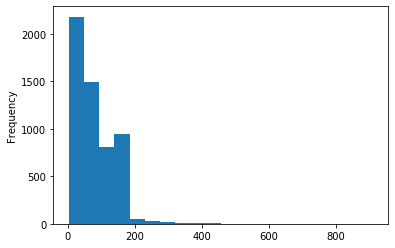

In [5]:
messages.length.plot(bins=20, kind='hist')

In [6]:
messages.length.describe()

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

Find and print that really long one...

In [7]:
messages['message'].iloc[messages['length'].idxmax()]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

We can see if there is there any difference in message length between spam and ham by running the following code to plot them side by side. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2694540190>,
      dtype=object)

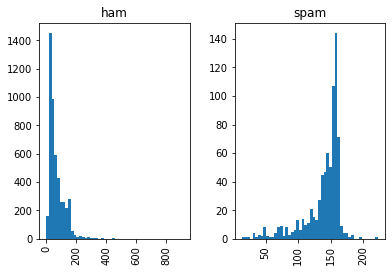

In [8]:
messages.hist(column='length', by='label', bins=50)

Great, but this is not sufficient for us to create a classifier.  We need machine learning!

## Part 2: Data preprocessing

Next we convert the raw messages (sequence of characters) into vectors (sequences of numbers).

The mapping is not 1-to-1; we'll use the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.

As a first step, here is a function that will split a message into its individual words:

In [9]:
def split_into_tokens(message):
    return TextBlob(message).words

You should tokenize them by applying the split_into_tokens method to the message column of the dataframe in the following cell.  Print the results to convince yourself that they are correct.  You do not need to store these results back in the dataframe.  

In [10]:
count_test = messages["message"].map(lambda token: split_into_tokens(token))
count_test.head(10)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
5    [FreeMsg, Hey, there, darling, it, 's, been, 3...
6    [Even, my, brother, is, not, like, to, speak, ...
7    [As, per, your, request, 'Melle, Melle, Oru, M...
8    [WINNER, As, a, valued, network, customer, you...
9    [Had, your, mobile, 11, months, or, more, U, R...
Name: message, dtype: object

With textblob, we can detect [part-of-speech (POS)](http://www.ling.upenn.edu/courses/Fall_2007/ling001/penn_treebank_pos.html) tags with:

In [11]:
TextBlob("Hello world, how is it going?").tags  # list of (word, POS) pairs

[('Hello', 'NNP'),
 ('world', 'NN'),
 ('how', 'WRB'),
 ('is', 'VBZ'),
 ('it', 'PRP'),
 ('going', 'VBG')]

In [12]:
def split_into_lemmas(message):
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

Normalize words into their base form ([lemmas](http://en.wikipedia.org/wiki/Lemmatisation)) by applying the split_into_lemmas function below to the message column of the dataframe.  Again, you do not need to store these results, so you can use `.head()` to view the output.  

In [13]:
lemma_test = messages["message"].map(lambda token: split_into_lemmas(token))
count_test.head(10)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
5    [FreeMsg, Hey, there, darling, it, 's, been, 3...
6    [Even, my, brother, is, not, like, to, speak, ...
7    [As, per, your, request, 'Melle, Melle, Oru, M...
8    [WINNER, As, a, valued, network, customer, you...
9    [Had, your, mobile, 11, months, or, more, U, R...
Name: message, dtype: object

You can probably think of many more ways to improve the preprocessing: decoding HTML entities (those `&amp;` and `&lt;` we saw above); filtering out stop words (pronouns etc); adding more features, such as an word-in-all-caps indicator and so on.  So keep those in mind for later...

## Part 3: Data to vectors

Now need to convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Doing that requires essentially three steps, in the bag-of-words model:

1. counting how many times does a word occur in each message (term frequency)
2. weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
3. normalizing the vectors to unit length, to abstract from the original text length


Each vector has as many dimensions as there are unique words in the SMS corpus.  We can count the number of unique words using the following cell...

In [14]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print(len(bow_transformer.vocabulary_))

11010


Here we used `scikit-learn` (`sklearn`), a powerful Python library for teaching machine learning. It contains a multitude of various methods and options.

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [15]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [16]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 4189)	2
  (0, 4762)	1
  (0, 5363)	1
  (0, 6219)	1
  (0, 6243)	1
  (0, 7137)	1
  (0, 9280)	2
  (0, 9589)	1
  (0, 10054)	1
(1, 11010)


So, nine unique words are in this message.  Two of them appear twice, the rest only once. 

Write some code in the next cell that identifies the words that appear twice.  You are encouraged to use the CountVectorizer's get_feature_names() method to make this easier

In [17]:
print((bow_transformer.get_feature_names())[4189])
print((bow_transformer.get_feature_names())[9280])

U
say


The bag-of-words counts for the entire SMS corpus are a large, sparse matrix (generated using `bow_transformer.transform()` on the appropriate dataframe column).  In the following cell, calculate the sparsity using `.nnz` and the shape.  

In [18]:
messages_bow = bow_transformer.transform(messages['message'])
messages_bow_nnz = messages_bow.nnz
messages_bow_shape = messages_bow.shape
sparsity = 1 - (messages_bow_nnz)/(messages_bow_shape[0]*messages_bow_shape[1])
print(sparsity)

0.9986699797000932


Next, lets see what the bow array looks like if we convert it to a "dense" array and print it out.  Lots of 0s right?  We can calculate the storage required by using `sys.getsizeof(python_array)` so please add that call to the following cell.  The numpy array requires a different size measurement because it stores the array outside of Python, so you can use `numpy_array.data.nbytes` to find its size

In [19]:
messages_array = messages_bow.toarray()
print(messages_array)
print(sys.getsizeof(messages_array))
print(messages_bow.data.nbytes)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
490958032
652984


Term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`, and we can apply it to the message we used above.  

In [20]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 10054)	0.22510385070095637
  (0, 9589)	0.1955442748962185
  (0, 9280)	0.49597495370832545
  (0, 7137)	0.4269339327922034
  (0, 6243)	0.3100112284407115
  (0, 6219)	0.2913528957227454
  (0, 5363)	0.2860779240943588
  (0, 4762)	0.25892595706356525
  (0, 4189)	0.391088549792437


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [21]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5574, 11010)


## Part 4: Training a model, detecting spam

With messages represented as vectors, we can finally train our spam/ham classifier.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier:

In [22]:
spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

Let's try classifying our single random message:

In [23]:
print('predicted:', spam_detector.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


Hooray!

A natural question is to ask, how many messages do we classify correctly overall?  The following cell will calculate this for us...

In [24]:
all_predictions = spam_detector.predict(messages_tfidf)
print('accuracy', accuracy_score(messages['label'], all_predictions))

accuracy 0.9721923214926445


There are quite a few possible metrics for evaluating model performance. Which one is the most suitable depends on the task. For example, the cost of mispredicting "spam" as "ham" is probably much lower than mispredicting "ham" as "spam".  Differences between errors can be illuminated using metrics other than accuracy, so in the following cell, and in the cells below, you should use sklearn to calculate recall and precision in addition to accuracy.  Please include statements about what you can interpret from these results

## Part 5: Let's get realistic

In the above "evaluation", we committed a cardinal sin. For simplicity of demonstration, we evaluated accuracy on the same data we used for training. **Never evaluate on the same dataset you train on!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.  This is exactly like memorizing the exact answers for an exam without understanding the underlying material!

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way -- thanks to this process, we make sure we are not "cheating", and that our final evaluation on test data is representative of true predictive performance.

The following code splits the dataset into a training and testing set.  

In [25]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.20)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4459 1115 5574


So, as requested, the test size is 20% of the entire dataset.

Next, lets set up our split datasets to be ready to be used by the Bayes model for training and prediction...

In [26]:
train_messages_bow = bow_transformer.transform(msg_train)
train_tfidf_transformer = TfidfTransformer().fit(train_messages_bow)
train_messages_tfidf = train_tfidf_transformer.transform(train_messages_bow)
test_messages_bow = bow_transformer.transform(msg_test)
test_tfidf_transformer = TfidfTransformer().fit(test_messages_bow)
test_messages_tfidf = test_tfidf_transformer.transform(test_messages_bow)

We can train a new Naive Bayes classifier with only the training data, and test it with the test data, and our accuracy should drop.  In this cell answer: why? 

The accuracy should drop as the test data will most likely contain words not found in the training data. This makes logical sense as the model only knows what it has been taught. If XXX is a spam word, but the model hasn't been told that, then it can't be expected to know XXX is spam.

In [27]:
split_spam_detector = MultinomialNB().fit(train_messages_tfidf, label_train)
test_predictions = split_spam_detector.predict(test_messages_tfidf)
print('updated accuracy', accuracy_score(label_test, test_predictions))

updated accuracy 0.9641255605381166


Next, re-run this experiment changing the test size to a different value (in the subsequent cells of this part) and develop an explanation for the results (it should be different than your accuracy value)

In [28]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.20)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

train_messages_bow = bow_transformer.transform(msg_train)
train_tfidf_transformer = TfidfTransformer().fit(train_messages_bow)
train_messages_tfidf = train_tfidf_transformer.transform(train_messages_bow)
test_messages_bow = bow_transformer.transform(msg_test)
test_tfidf_transformer = TfidfTransformer().fit(test_messages_bow)
test_messages_tfidf = test_tfidf_transformer.transform(test_messages_bow)

split_spam_detector = MultinomialNB().fit(train_messages_tfidf, label_train)
test_predictions = split_spam_detector.predict(test_messages_tfidf)
print('updated accuracy', accuracy_score(label_test, test_predictions))

4459 1115 5574
updated accuracy 0.9506726457399103


In [29]:
train_messages_tfidf.shape

(4459, 11010)

With a test sample of 50% the accuracy was 93.94%, whereas the previous example of 20% had an accuracy rating of 95.96%. This very slight decrease of 2.02% is easily explained by the frequency of spam in the dataset and the model's lack of knowledge. The size of the decrease in accuracy is caused by the dataset having a low amount of spam. If the amount of spam is low then the change in accuracy would also be low. The decrease in accuracy is caused by the model's lack of knowledge. As was stated earlier, the model won't be able to identitfy every case of spam without knowing every case of spam.

## Part 6: Next Steps

In the following cells you should make some changes to the dataset (cast to lowercase, remove numbers, remove non-words, add content, etc) to sufficiently change the sparsity percentage.  The number of columns in your bag of words model should be significantly smaller.  The goal of this is see the size comparison in the non-compressed version of the matrix (`toarray`) vs the sparse representation as the size of the data changes.  If we didn't have a sparse representation, our ability to use a BOW model would be very limiting...

Run the experiments again to assess the accuracy of your new dataset and compare it with your previous results.  You should make arguments about what caused the changes and why they make sense.  Calculate and compare the storage requirements of the non-sparse and sparse representations, and argue how using sparse matricies can enable better accuracy.  

Takes in a string and deletes it if it has less than 4 letters.

**Param** word: string to be tested
**Return**:A string that is either 0 in length or greater than 3

In [30]:
def remove_small_string(word):
    shortword = re.compile(r'\W*\b\w{1,3}\b')
    return(shortword.sub('', word))

In [31]:
import re
#Data set with only lower case letters and words greater than 3 chars
messages_mod = pandas.DataFrame()
messages_mod["label"] = messages["label"]
messages_mod["message"] = messages["message"].str.replace('[^a-z, \']', '')
messages_mod["message"] = messages_mod["message"].map(lambda token: remove_small_string(token))
messages_mod["length"] = messages_mod["message"].str.len()
messages_mod.head()

,label,message,length
0,ham,"until jurong point, crazy vailable only bugis...",77
1,ham,oking,6
2,spam,entry wkly comp final tkts receive entry ques...,69
3,ham,early already then,19
4,ham,think goes lives around here though,36


In [32]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages_mod['message'], messages_mod['label'], test_size=0.20)
print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

bow_transformer_mod = CountVectorizer(analyzer=split_into_lemmas).fit(messages_mod['message'])

train_messages_bow = bow_transformer_mod.transform(msg_train)
train_tfidf_transformer = TfidfTransformer().fit(train_messages_bow)
train_messages_tfidf = train_tfidf_transformer.transform(train_messages_bow)
test_messages_bow = bow_transformer_mod.transform(msg_test)
test_tfidf_transformer = TfidfTransformer().fit(test_messages_bow)
test_messages_tfidf = test_tfidf_transformer.transform(test_messages_bow)

split_spam_detector = MultinomialNB().fit(train_messages_tfidf, label_train)
test_predictions = split_spam_detector.predict(test_messages_tfidf)
print('updated accuracy', accuracy_score(label_test, test_predictions))

4459 1115 5574
updated accuracy 0.9461883408071748


In [33]:
#Sparsity Calculations
messages_mod_bow = bow_transformer_mod.transform(messages_mod['message'])
messages_mod_bow_nnz = messages_mod_bow.nnz
messages_mod_bow_shape = messages_mod_bow.shape
sparsity_mod = 1 - (messages_mod_bow_nnz)/(messages_mod_bow_shape[0]*messages_mod_bow_shape[1])
print(sparsity_mod)

0.9990641173172639


In [34]:
#Size of the bag of words
messages_mod_array = messages_mod_bow.toarray()
print(messages_mod_bow.shape)
print(sys.getsizeof(messages_mod_array))
print(messages_mod_bow.data.nbytes)

(5574, 7068)
315176368
294968


## Conclusion  
**Accuracy**  
The modified dataset at 20% test size had an accuracy rate difference of +0.90%. This increase in accuracy can be attributed to the smaller dataset. Most text lingo utilize short versions of words such as "u" for "you" and "4" for "four". By removing these type of words, the model would have to sift through less data, thus the probability of learning data increases due to the higher chance of spam related words being fed into the model.  

**Sparcity**  
The modified dataset had a difference in sparcity value of  +0.04%. This increase in sparcity can again be attributed to removing alphabetized words and words less than 3 chars in length. By removing captial letters, we effectively split the rate of occurance of 5+ char words between the lowercase and uppercase versions, thus increasing the amount of columns in the sparcity matrix.  

**Bag of words**  
The modified dataset had a difference in the number of columns in the bag of words of -35.80%, and a difference in size of -54.83%. This decrease in the bag of words size can be attributed to the total amount of words lost due to remove all non-lowercase chars and words with less than 3 chars. Less words in the data set means a smaller bag of words. Texting lingo typically contains simple words and use of numbers, meaning the likelyhood of using 3-letter words is higher than other forms of communication.  

**Bag of words**  
Comparing the size of the dense array to the sparse array for the bag of words, we can clearly see the incredible data compression sparcity allows. The sparse bag of words is 294,968 Bytes while the dense version is 315,176,368 Bytes; a difference of 99.91%. This dramatic size difference would also translate to faster calculations as less data needs to be fed into the algorithm.